In [1]:
from src import *
from utils import *
import os
import os.path as osp
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import cPickle
import torch

In [2]:
config_dict = {
    'gpu': 0, 
    #'resume': './logs/20200717_213226.282957/',
    'resume': False,
    
    'max_iteration': 500000,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'momentum': 0.99,
    'batch_size': 5,
    'model': 'fcn8',
    'n_class': 0+1,
    'interval_validate': 10000,
}

# log diectory 생성
#here = osp.dirname(osp.abspath(__file__))
here = osp.dirname('./')

now = datetime.datetime.now()
out = osp.join(here, 'logs', now.strftime('%Y%m%d_%H%M%S.%f'))

os.makedirs(out)
config_dict['out'] = out # log output directory 넣어줌
args = DictToObject(config_dict)

# GPU선정
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
cuda = torch.cuda.is_available()


# data loader

In [3]:
label_df = pd.read_csv('./train_answer.csv')


In [4]:
label_df.columns[1:args.n_class]

Index([], dtype='object')

In [5]:
# data loader

# 앞에서 9만번까지는 train 그 다음은 valid로 사용
train_dir_list = np.sort(glob.glob('./train/*.wav'))[:90000]
valid_dir_list = np.sort(glob.glob('./train/*.wav'))[90000:]

train_dataset = GetTrainDataset(train_dir_list, class_list=label_df.columns[1:args.n_class]) 
valid_dataset = GetTrainDataset(valid_dir_list, class_list=label_df.columns[1:args.n_class]) 

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지

# model

In [6]:
model = CAMAE8s(n_class=args.n_class)
start_epoch = 0
start_iteration = 0
if args.resume:
    checkpoint = torch.load(args.resume+'/checkpoint.pth.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']

if cuda:
    model = model.cuda()
    
# optim = torch.optim.SGD(model.parameters(),
# # optim = torch.optim.RMSprop(model.parameters(),
#     lr=args.lr,
#     momentum=args.momentum,
#     weight_decay=args.weight_decay)

optim = torch.optim.Adam(model.parameters(),
    lr=args.lr,
    weight_decay=args.weight_decay)

if args.resume:
    optim.load_state_dict(checkpoint['optim_state_dict'])

In [7]:
trainer = PreTrainer(
    cuda=cuda,
    model=model,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=valid_loader,
    out=args.out, # log output director
    max_iter=args.max_iteration,
    n_class=args.n_class,
    interval_validate=args.interval_validate,
)

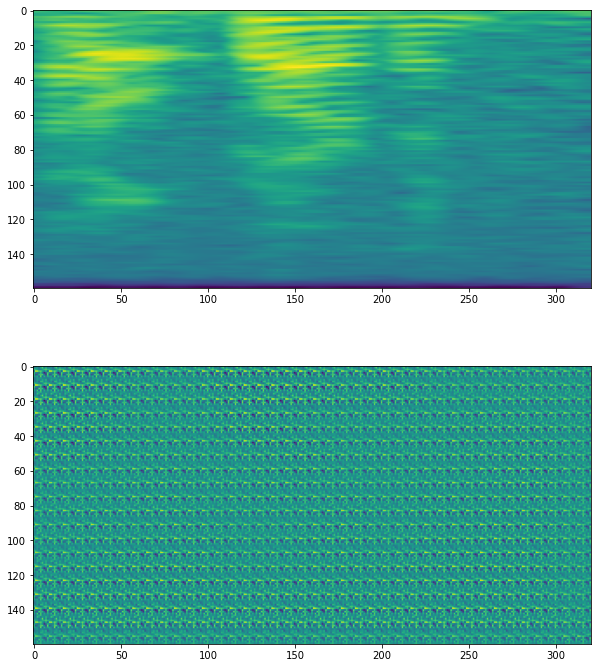

 iteration : 9999, loss :                0.014

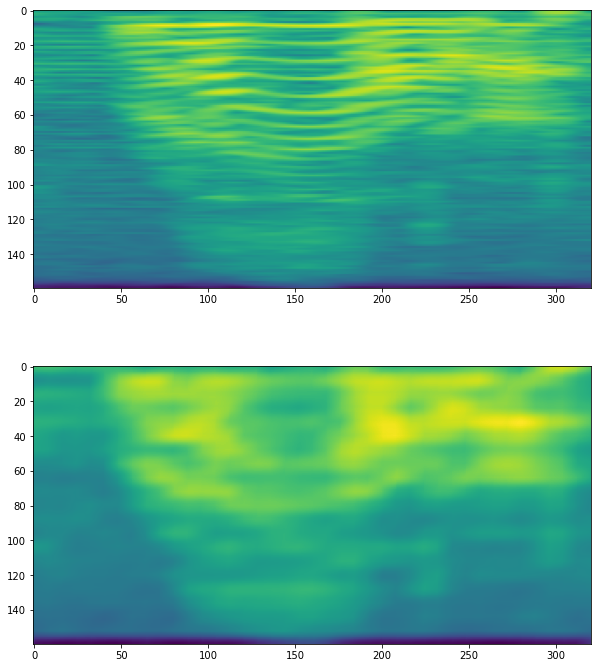

 iteration : 17999, loss :               0.0169

 iteration : 19999, loss :               0.0186

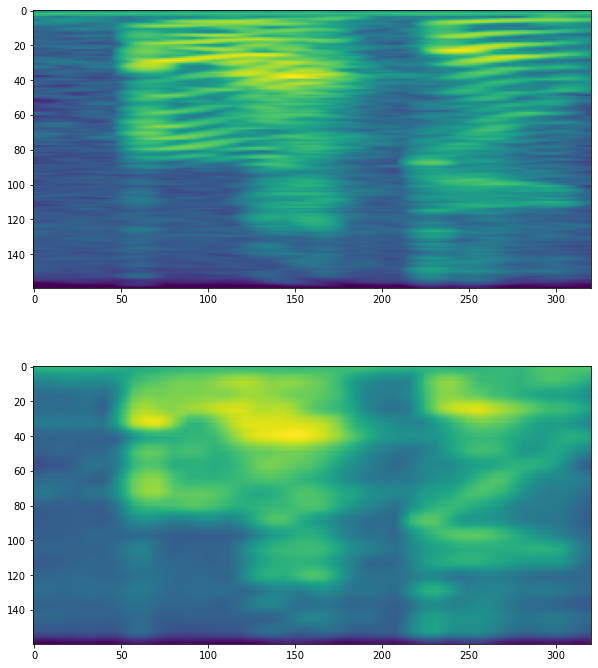

 iteration : 29999, loss :               0.0371

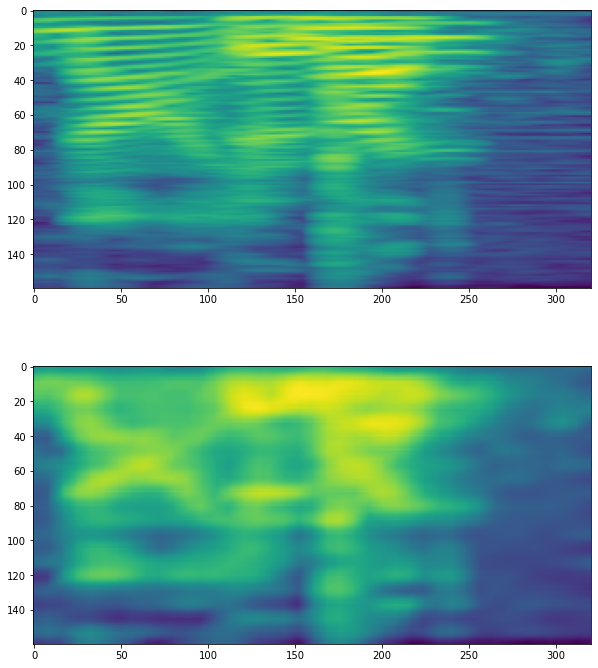

 iteration : 35999, loss :               0.0128

 iteration : 39999, loss :               0.0165

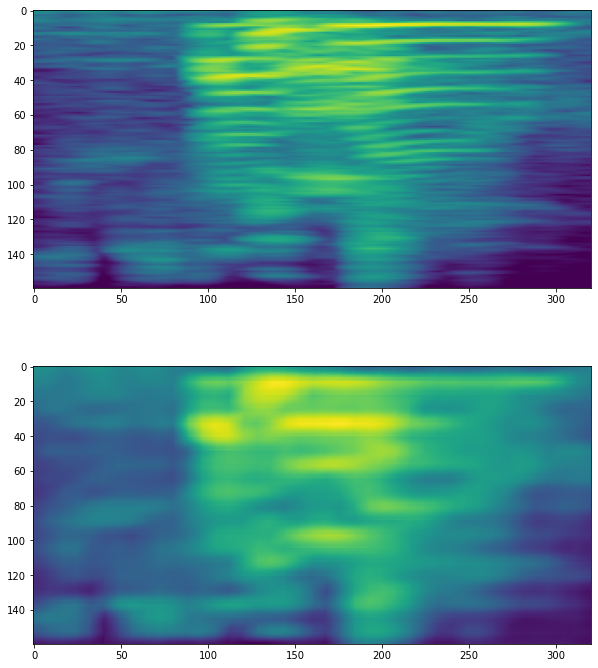

 iteration : 49999, loss :               0.0206

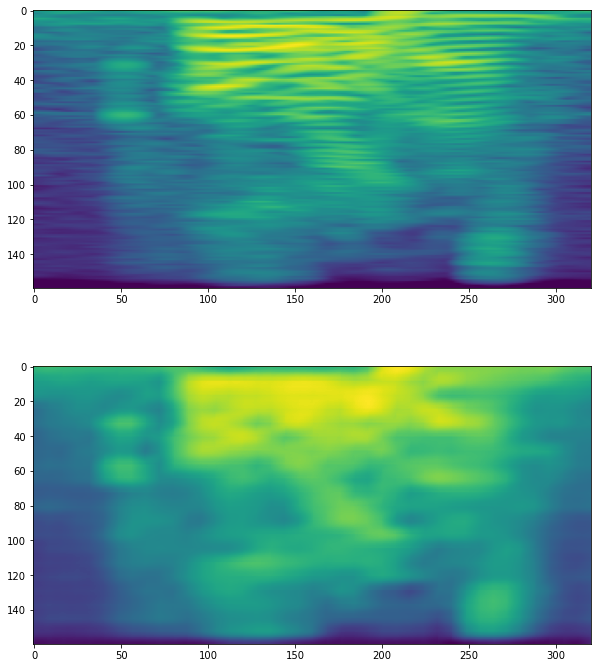

 iteration : 53999, loss :               0.0227

 iteration : 59999, loss :               0.0215

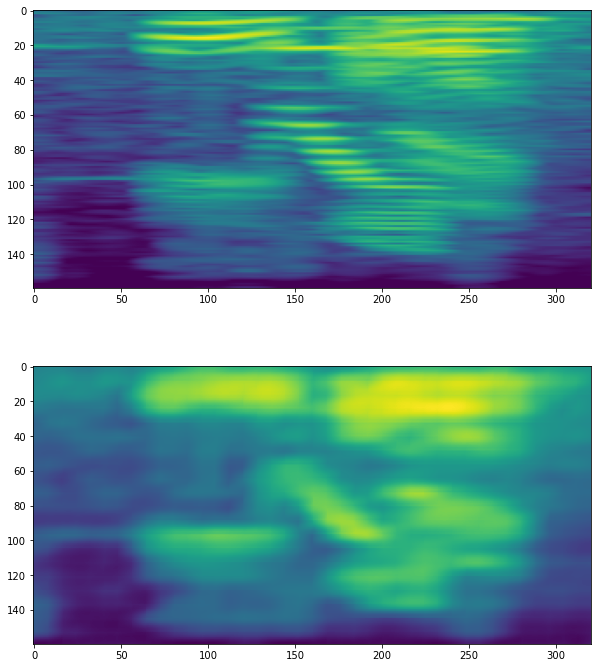

 iteration : 69999, loss :               0.0234

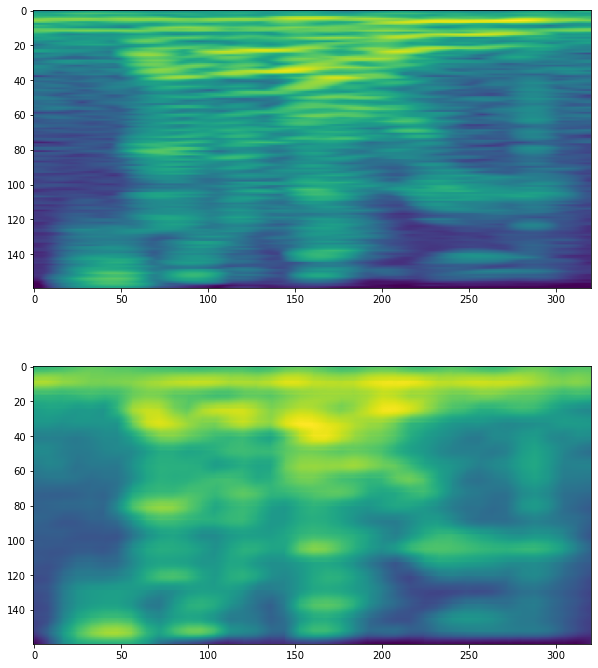

 iteration : 71999, loss :               0.0243

 iteration : 76121, loss :               0.0191


KeyboardInterrupt: 

In [8]:
#trainer.epoch = start_epoch
#trainer.iteration = start_iteration
trainer.train()